# HomeMatch: Personalised Real State Agent

This project is an mult-modal **Home Matching** Personalised Real State AI Agent using Open AI models (GPT and CLIP), Langchain and LanceDB. The agent ustilses Large Language and Vision Models to capture semantic and visual features of real states. Special type of database called Vector Database was used to store and retrieve the semantic and visual features.

## Setup environment

In [37]:
# This is if you are using google drive and you want to save your data on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
homedir = "/content/drive/MyDrive/Learning/Gen-AI-Udacity/05/project"
%cd $homedir

/content/drive/MyDrive/Learning/Gen-AI-Udacity/05/project


In [3]:
!pip install -q torch pandas transformers lancedb gradio tqdm matplotlib torchvision torch
!pip install -q langchain==0.0.305 langchain_community
!pip install -q openai==0.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7

## Import libraries

In [6]:
import os, io
from PIL import Image

# Set up your OpenAI API key as an environment variable.
os.environ["OPENAI_API_KEY"] = "voc-379368067126677338956666a0c6ab2b3362.58156147"
# Set up the base URL for the OpenAI API, pointing to a custom endpoint (Vocareum in this case).
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"

# Import necessary libraries
import torch
import pandas as pd
import lancedb  # A library used for vector or embedding databases

# Import custom tools/modules for data generation and processing.
from data_gen_tools import (generate_synthetic_real_state_data,  # Function for generating synthetic real estate data.
                            generate_real_state_images           # Function for generating real estate images.
                            )

# Import custom embedding-related utilities for embedding vectors, text, images, and database operations.
from embed_vect_db_tools import (embed_image,                    # Function to embed images into vector space.
                                 get_clip_model,                 # Function to load or get the CLIP model.
                                 embed_text,                     # Function to embed text into vector space.
                                 get_text_image_embedding,       # Function to get combined embeddings for text and images.
                                 clean_synthetic_data,           # Function to clean generated synthetic data.
                                 RealState,                      # Schema or structure representing real estate data.
                                 create_housematch_vec_db,        # Function to create a vector database for house matching.
                                 copy_database
                                 )

# Import semantic search and app tools.
from semantic_search_tools import (generate_personalized_descriptions,  # Function to generate personalized property descriptions.
                                  capture_user_preferences # Function  parse user preference as prompt for LLM
                                   )


# Import the house matching application logic.
from house_match_app import house_matcher_app  # Graphical user interface for collecting user preference and displaying results


In [7]:
# Define the name of the OpenAI generative model to be used (GPT-3.5-turbo).
openai_generative_model = "gpt-3.5-turbo" # "gpt-4o-2024-08-06"

# Define the name of the OpenAI embedding model (small version).
# openai_embedding_model = "text-embedding-3-small"

# Set the name of the CLIP (Contrastive Language-Image Pretraining) model for image-text embedding (from OpenAI).
clip_model_name = "openai/clip-vit-base-patch32"

# Set the model name for OpenAI's image generation (DALL·E 2).
open_ai_image_gen_model = "dall-e-2"

# Specify the number of houses (potentially for a generative task).
num_houses = 20

# Create the path where data will be stored by joining the home directory and 'data' folder.
output_path = os.path.join(homedir, 'data_')

# Create the directory specified by output_path if it does not already exist.
os.makedirs(output_path, exist_ok=True)

# Set the device to GPU (CUDA) if available, otherwise use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Generate Synthetic Data

### 1. Generate house description using langchain and openai

Generating synthetic real estate house data involves creating realistic data entries.

In [54]:
# Define the list of features (columns) for the synthetic real estate data
features = ["title", "bedrooms", "bathrooms", "area", "zipcode", "price", "city", "street",
            "description", "neighbourhood"]

# Generate the synthetic real estate data using the defined features and number of houses
synthetic_real_state_data = generate_synthetic_real_state_data(model_name=openai_generative_model,
                                                               num_houses=num_houses,
                                                               columns=features)

# Save the generated synthetic data to a CSV file in the specified output path
synthetic_real_state_data.to_csv(os.path.join(output_path, "synthetic_data.csv"), index=False)


/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:202: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:790: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [56]:
# Distplay the first three real states
synthetic_real_state_data.head(3)

,title,bedrooms,bathrooms,area,zipcode,price,city,street,description,neighbourhood
0,Luxurious Townhouse in Central London,4,3,3000 sqft,SW1A,"£2,500,000",London,Belgravia Street,This stunning townhouse offers spacious living...,"Belgravia is known for its upscale atmosphere,..."
1,Family Home in Manchester Suburb,3,2,2000 sqft,M20,"£400,000",Manchester,Didsbury Road,This charming family home features a spacious ...,Didsbury is a vibrant neighborhood with a stro...
2,Historic Townhouse in Edinburgh Old Town,5,4,3500 sqft,EH1,"£1,800,000",Edinburgh,Royal Mile,This historic townhouse boasts original featur...,"Old Town is a UNESCO World Heritage Site, know..."


## 2. Generate real state images

We want our house matching AI agent to have multimodal search capability. Normally, real states have the image of the houses. Here, we generate image of the houses using `OpenAI DALL-E 2` [here](https://platform.openai.com/docs/api-reference/images/create) using the `openai.Image.create` endpoint.

This is a two step process:
1. The house description was formated from teh generated data.
2. The house description was fed to OpenAI DALL-E pipeline to generate image.

Have a look the implementation of `generate_real_state_images(...)` function for detail.

In [8]:
# Load the synthetic real estate data from a CSV file into a pandas DataFrame.
# The file is located in the 'output_path' directory, and the file name is 'synthetic_data.csv'.
synthetic_real_state_data = pd.read_csv(os.path.join(output_path, "synthetic_data.csv"))

# Generate real estate images using the specified model.
images_dir = os.path.join(output_path, 'synthetic_images')
generate_real_state_images(model_name=open_ai_image_gen_model,
                           synthetic_data=synthetic_real_state_data,
                           output_dir=images_dir)


Generating 21 images


Generate images: 100%|██████████| 21/21 [03:43<00:00, 10.66s/it]


## Visualise sample images

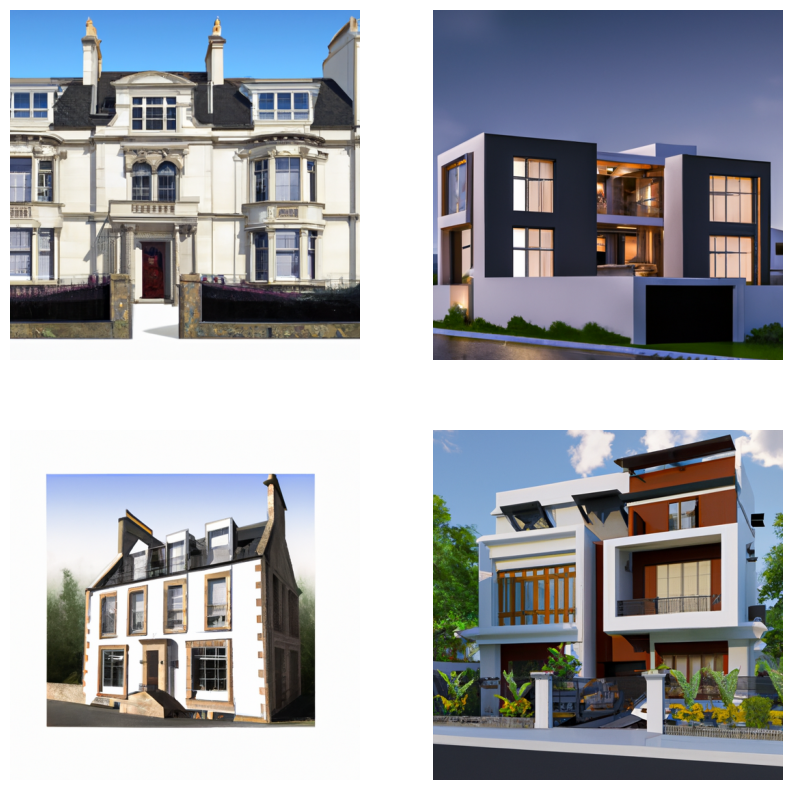

In [9]:
import matplotlib.pyplot as plt
import random
images_dir = os.path.join(output_path, 'synthetic_images')

images = os.listdir(images_dir)
random.shuffle(images)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
  ax.imshow(Image.open(os.path.join(images_dir, images[i])))
  ax.axis("off")



## Multimodal semantic search

To enable multimodal (semantic and visual search), the multimodal data embedding need to stored in a vector or embedding database.


## Multimodal embedding and vector store

To enable effective multimodal search, we need to create embeddings for both text descriptions and images of houses. These embeddings will be used to store and retrieve data in a vector database. For detailed explantion read the `readme` file.




## Vector database table creation

In [10]:
db_name = "vector-store"
table_name = 'housemacher'

In [11]:
# Connect to an existing LanceDB database.
db = lancedb.connect(f"/content/{db_name}")

# Create a new table named 'housemacher' in the database with the schema defined by the RealState class.
# If the table already exists, it will be overwritten.
house_tbl = db.create_table(table_name, schema=RealState, mode='overwrite')


## Add data to vector database

In [12]:
# Load the CLIP model, processor, and tokenizer for image-text embeddings.
clip_model, clip_processor, clip_tokenizer = get_clip_model(clip_model=clip_model_name,
                                                            device=device)

# Load the synthetic real estate data from the CSV file into a pandas DataFrame.
synthetic_real_state_data = pd.read_csv(os.path.join(output_path, 'synthetic_data.csv'))

# Clean the synthetic real estate data using a custom function to ensure it's in the correct format.
synthetic_real_state_data = clean_synthetic_data(synthetic_real_state_data)

# Create a vector database for house matching by processing the synthetic data and images.
create_housematch_vec_db(synthetic_real_state_data,
                         clip_model,
                         clip_processor,
                         clip_tokenizer,
                         os.path.join(output_path, 'synthetic_images'),
                         house_tbl, device)

## Copy database: COMMENT OUT THIS IF YOU DO NOT WANT TO COPY IT TO OUTPUT FOLDER
copy_database(src_dir='/content', dst_dir=output_path, db_name=db_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
creating vector database:   0%|          | 0/21 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 77). Running this sequence through the model will result in indexing errors


house description: This stunning townhouse offers spacious living areas, a modern kitchen, a private garden, and beautiful views of the city skyline. Located in the prestigious neighborhood of Belgravia, it is within walking distance to top schools, restaurants, and shops. Belgravia is known for its upscale atmosphere, with tree-lined streets and elegant Georgian architecture. It is a short distance from Buckingham Palace and Hyde Park, and offers easy access to public transportation.


creating vector database:   5%|▍         | 1/21 [00:01<00:21,  1.09s/it]

house description: This charming family home features a spacious living room, a modern kitchen with a breakfast bar, a large backyard with a patio, and a garage. Situated in the leafy suburb of Didsbury, it is close to schools, parks, and local amenities. Didsbury is a vibrant neighborhood with a strong sense of community. It offers a range of cafes, restaurants, and shops, as well as excellent transport links to the city center.


creating vector database:  10%|▉         | 2/21 [00:01<00:16,  1.18it/s]

house description: This historic townhouse boasts original features, including exposed stone walls and a grand staircase. It offers a spacious kitchen, a formal dining room, a private courtyard garden, and views of Edinburgh Castle. Located in the heart of Old Town, it is surrounded by historic landmarks and cultural attractions. Old Town is a UNESCO World Heritage Site, known for its medieval architecture and narrow cobblestone streets. It is home to a variety of restaurants, galleries, and boutiques, and is within walking distance to Edinburgh Waverley train station.


creating vector database:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

house description: This sleek apartment features an open-plan living area, a designer kitchen with integrated appliances, a balcony with city views, and underground parking. Situated in the vibrant neighborhood of Covent Garden, it is surrounded by theaters, restaurants, and shops. Covent Garden is a bustling district known for its street performers, markets, and cultural attractions. It offers excellent transport links, including Covent Garden tube station and numerous bus routes.


creating vector database:  19%|█▉        | 4/21 [00:03<00:12,  1.37it/s]

house description: This detached house offers a spacious living room, a modern kitchen with a dining area, a landscaped garden with a patio, and a driveway for multiple cars. Located in the popular suburb of Fallowfield, it is close to schools, parks, and local amenities. Fallowfield is a vibrant neighborhood popular with students and young professionals. It offers a range of bars, cafes, and shops, as well as easy access to public transportation.


creating vector database:  24%|██▍       | 5/21 [00:03<00:11,  1.38it/s]

house description: This elegant townhouse features high ceilings, period details, a grand entrance hall, a formal drawing room, and a landscaped rear garden. Situated in the prestigious New Town, it is within walking distance to top schools, galleries, and boutiques. New Town is a UNESCO World Heritage Site known for its Georgian architecture and elegant squares. It offers a range of upscale restaurants, bars, and shops, as well as easy access to public transportation.


creating vector database:  29%|██▊       | 6/21 [00:04<00:10,  1.41it/s]

house description: This stylish apartment offers panoramic views of the River Thames, a modern kitchen with integrated appliances, a balcony overlooking the water, and underground parking. Located in the vibrant neighborhood of Canary Wharf, it is surrounded by restaurants, bars, and shops. Canary Wharf is a major financial district with a lively waterfront atmosphere. It offers a range of amenities, including shopping centers, parks, and cultural venues, as well as excellent transport links.


creating vector database:  33%|███▎      | 7/21 [00:05<00:09,  1.40it/s]

house description: This Victorian terrace house features original fireplaces, sash windows, a modern kitchen with a breakfast bar, and a small courtyard garden. Situated in the heart of the city center, it is within walking distance to restaurants, theaters, and shopping centers. Manchester City Centre is a vibrant area with a mix of historic and modern architecture. It offers a range of cultural attractions, including museums and galleries, as well as excellent transport links.


creating vector database:  38%|███▊      | 8/21 [00:05<00:09,  1.40it/s]

house description: This contemporary penthouse boasts floor-to-ceiling windows, a designer kitchen with Miele appliances, a private terrace with city views, and secure underground parking. Located in the prestigious West End, it is close to top schools, galleries, and boutiques. West End is a desirable neighborhood known for its elegant Georgian townhouses and upscale boutiques. It offers a range of restaurants, cafes, and bars, as well as easy access to public transportation.


creating vector database:  43%|████▎     | 9/21 [00:06<00:08,  1.42it/s]

house description: This modern townhouse features an open-plan living area, a sleek kitchen with quartz countertops, a landscaped garden with a deck, and a garage. Situated in the historic neighborhood of Greenwich, it is close to parks, markets, and cultural attractions. Greenwich is a UNESCO World Heritage Site known for its maritime history and royal connections. It offers a range of amenities, including museums, theaters, and parks, as well as excellent transport links.


creating vector database:  48%|████▊     | 10/21 [00:07<00:07,  1.43it/s]

house description: This family home offers a spacious living room, a modern kitchen with a dining area, a landscaped garden with a patio, and off-street parking. Located in the popular suburb of Chorlton, it is close to schools, parks, and local amenities. Chorlton is a trendy neighborhood with a bohemian vibe. It offers a range of independent shops, cafes, and bars, as well as easy access to public transportation.


creating vector database:  52%|█████▏    | 11/21 [00:08<00:07,  1.41it/s]

house description: This traditional townhouse features period details, a formal dining room, a country-style kitchen with an Aga stove, and a private walled garden. Situated in the charming neighborhood of Stockbridge, it is close to boutique shops, cafes, and green spaces. Stockbridge is a picturesque area known for its village-like atmosphere and artisanal food scene. It offers a range of amenities, including farmers' markets, galleries, and riverside walks, as well as easy access to public transportation.


creating vector database:  57%|█████▋    | 12/21 [00:08<00:06,  1.42it/s]

house description: This modern apartment features an open-plan living area, a designer kitchen with integrated appliances, a balcony with city views, and underground parking. Located in the trendy neighborhood of Shoreditch, it is surrounded by street art, cafes, and boutiques. Shoreditch is a creative hub known for its vibrant street art scene and eclectic mix of shops and restaurants. It offers a range of cultural attractions, including galleries and theaters, as well as excellent transport links.


creating vector database:  62%|██████▏   | 13/21 [00:09<00:05,  1.43it/s]

house description: This detached house offers a spacious living room, a modern kitchen with a breakfast bar, a landscaped garden with a patio, and a driveway for multiple cars. Located in the leafy suburb of Didsbury, it is close to schools, parks, and local amenities. Didsbury is a sought-after neighborhood with a strong sense of community. It offers a range of cafes, restaurants, and shops, as well as excellent transport links to the city center.


creating vector database:  67%|██████▋   | 14/21 [00:10<00:05,  1.36it/s]

house description: This Georgian townhouse boasts period features, including sash windows and ornate cornices, a grand entrance hall, a formal drawing room, and a landscaped rear garden. Situated in the picturesque Dean Village, it is surrounded by green spaces and historic landmarks. Dean Village is a hidden gem nestled along the Water of Leith. It offers a tranquil setting with riverside walks, quaint cottages, and a sense of seclusion, while still being within walking distance to the city center.


creating vector database:  71%|███████▏  | 15/21 [00:11<00:05,  1.19it/s]

house description: This riverside apartment offers stunning views of the Thames, a modern kitchen with integrated appliances, a balcony overlooking the water, and underground parking. Located in the vibrant neighborhood of Battersea, it is surrounded by parks, cafes, and cultural venues. Battersea is a popular area known for its green spaces and riverside setting. It offers a range of amenities, including Battersea Park, Chelsea Embankment, and Battersea Power Station, as well as excellent transport links.


creating vector database:  76%|███████▌  | 16/21 [00:12<00:04,  1.12it/s]

house description: This Victorian terrace house features original fireplaces, sash windows, a modern kitchen with a breakfast bar, and a small courtyard garden. Situated in the trendy Northern Quarter, it is within walking distance to bars, restaurants, and cultural venues. Northern Quarter is a vibrant district known for its independent shops, art galleries, and music venues. It offers a range of dining options, including hip cafes and craft beer bars, as well as easy access to public transportation.


creating vector database:  81%|████████  | 17/21 [00:13<00:03,  1.06it/s]

house description: This contemporary penthouse boasts floor-to-ceiling windows, a designer kitchen with Miele appliances, a private terrace with views of the waterfront, and secure underground parking. Located in the vibrant neighborhood of Leith, it is surrounded by trendy bars, restaurants, and shops. Leith is a lively area with a maritime heritage and a creative community. It offers a range of amenities, including the Ocean Terminal shopping center, the Royal Yacht Britannia, and a variety of waterside eateries, as well as easy access to public transportation.


creating vector database:  86%|████████▌ | 18/21 [00:14<00:02,  1.03it/s]

house description: This modern townhouse features an open-plan living area, a sleek kitchen with quartz countertops, a landscaped garden with a deck, and a garage. Situated in the trendy neighborhood of Notting Hill, it is close to markets, cafes, and cultural attractions. Notting Hill is a fashionable area known for its colorful houses, upscale boutiques, and the famous Portobello Road Market. It offers a range of dining options, including trendy cafes and Michelin-starred restaurants, as well as excellent transport links.


creating vector database:  90%|█████████ | 19/21 [00:15<00:01,  1.04it/s]

house description: This family home offers a spacious living room, a modern kitchen with a dining area, a landscaped garden with a patio, and off-street parking. Located in the leafy suburb of Didsbury, it is close to schools, parks, and local amenities. Didsbury is a sought-after neighborhood with a strong sense of community. It offers a range of cafes, restaurants, and shops, as well as excellent transport links to the city center.


creating vector database:  95%|█████████▌| 20/21 [00:16<00:00,  1.10it/s]

house description: This traditional townhouse features period details, a formal dining room, a country-style kitchen with an Aga stove, and a private walled garden. Situated in the charming neighborhood of Morningside, it is close to boutique shops, cafes, and green spaces. Morningside is a leafy suburb known for its village-like atmosphere and independent boutiques. It offers a range of amenities, including parks, golf courses, and artisanal food shops, as well as easy access to public transportation.


creating vector database: 100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


In [13]:
## Copy database
# copy_database(src_dir='/content', dst_dir=output_path, db_name='vector-store')

## House maching

For house matching, I implemented an app to collect user preference. The app is built in `gradio`. It can be found in (`house_matcher_app(...)`). The app allows users:

1. To enter and submit their preferences
2. Interactively visualise the search results matching with their description. The app shows both images and description. The app is connected to a house matching logic.

4. The search logic finds and returns real estate listings that match user preferences by embedding the search query and comparing it with listings in a database. It uses both uses semantic search and SQL filtering to identify closely matching realstates. It retrieves matching listings, generates personalized descriptions, and provides images of the properties. It return images of the matching properties and a personalized description of the property to the user preference.

5. The `generate_personalized_descriptions` function generates personalised desctiption for a real estate listing based on user preferences and the details of the listing. This was achieved in these steps:

## House matching logic

In [18]:
def real_state_matcher(bedrooms,
                        bathrooms,
                        area,
                        price,
                        city,
                        important_features,
                        amenities,
                        transportation,
                        neighborhood):
    """
    Finds and returns real estate listings that match the user's preferences.

    This function searches a database of real estate listings based on user-defined criteria such as the number of bedrooms,
    bathrooms, area, price, city, important features, amenities, transportation, and neighborhood. It uses a CLIP model
    to embed the search query and find similar houses in the database. For each matching listing, the function retrieves
    images and generates personalized descriptions.

    Parameters:
    - bedrooms (int): The desired number of bedrooms.
    - bathrooms (int): The desired number of bathrooms.
    - area (float): The minimum area (in square feet or meters) of the property.
    - price (float): The maximum price of the property.
    - city (str): The city where the property is located.
    - important_features (list): A list of important features the property should have.
    - amenities (list): A list of desired amenities.
    - transportation (list): A list of transportation options or proximity requirements.
    - neighborhood (str): The desired neighborhood or area within the city.
    - topk (int): The number of top matching listings to return.

    Returns:
    - List of tuples: Each tuple contains:
        - An image of the matching property.
        - A personalized description of the property.
    """
    # Collect user preferences into a dictionary for processing.
    user_preferences = {
        "bedrooms": bedrooms,
        "bathrooms": bathrooms,
        "area": area,
        "price": price,
        "city": city,
        "important_features": important_features,
        "amenities": amenities,
        "transportation": transportation,
        "neighborhood": neighborhood
    }

    # Generate a query prompt based on user preferences.
    query_prompt = capture_user_preferences(user_preferences)

    # Search the database for similar houses.
    # - Convert the query prompt into a vector using CLIP model.
    # - Perform a search in the 'house_tbl' table based on the vector.
    # - Filter results by area and city, and limit the number of results to 'topk'.
    similar_houses = (house_tbl.search(embed_text(clip_model,
                                                   clip_tokenizer,
                                                   query_prompt).tolist(),
                                       vector_column_name='vector')
    .where(f"area >= {area} AND city = '{city}'", prefilter=True)
    .metric('cosine')
    .limit(3).to_pandas()
    )

    # List to store matching property images and descriptions.
    matching_listings = []

    # Process each matching house from the search results.
    for _, row in similar_houses.iterrows():
        # Load and resize the image associated with the listing.
        image = Image.open(io.BytesIO(row['image']))
        image = image.resize((256, 256))
        matching_listings.append(image)

        # Extract listing details, excluding vector columns.
        matched_listing_detail = dict()
        for name in row.index:
            if 'vector' in name:
                continue
            matched_listing_detail[name] = row[name]

        # Generate a personalized description of the real estate listing.
        personalised_desc = generate_personalized_descriptions(openai_generative_model,
                                                               matched_listing_detail,
                                                               user_preferences)
        matching_listings.append(personalised_desc)

    return matching_listings


## House matching using user input without app

In [25]:
matching_listing = real_state_matcher(bedrooms=2,
                        bathrooms=3,
                        area=1000,
                        price=200000,
                        city="London",
                        important_features="The three most important features I am looking include space, availability of transport connecting to city center and school for children.",
                        amenities="Large kitchen and big garden",
                        transportation="Proximity to bus stop and train station",
                        neighborhood="I am looking for a place with urban place")



Here are real states that you might be intereseted!
------------------------------------------------------------ 


Title: Modern Townhouse in London Notting Hill | London

 This charming townhouse in the vibrant neighborhood of Notting Hill offers a cozy living space with 2 bedrooms and 3 bathrooms, perfect for a small family. The open-plan living area is complemented by a spacious kitchen featuring quartz countertops, ideal for cooking and entertaining. Step outside to enjoy the landscaped garden with a deck, providing a peaceful retreat for relaxation and outdoor gatherings. Additionally, the property includes a garage for convenient parking.

Located in an urban setting, this home is within close proximity to bus stops and train stations, ensuring easy access to the city center for work or leisure. Nearby, you'll find schools for children, making it a convenient choice for families. The large kitchen and expansive garden cater to your desire for ample space and outdoor living. Embr

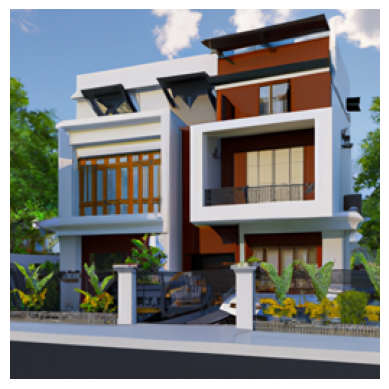

Title: Modern Townhouse in London Greenwich | London

 This charming townhouse in Greenwich offers a cozy living space with 2 bedrooms and 3 bathrooms, perfect for a small family. The open-plan living area is designed for comfort and functionality, with a modern kitchen featuring quartz countertops. The property includes a spacious garden with a deck, ideal for outdoor activities and relaxation. 

Located in the vibrant neighborhood of Greenwich, this home provides easy access to transportation options, including a nearby bus stop and train station connecting you to the city center. The area is known for its urban atmosphere, with parks, markets, and cultural attractions just a short distance away. 

For families with children, there are schools in the vicinity, ensuring convenience and accessibility. The property also boasts a large kitchen, meeting your preference for ample cooking space, and a generous garden area for outdoor enjoyment. 

Priced at 200,000 pounds, this townhouse off

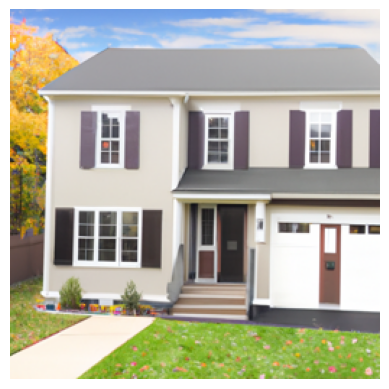

Title: Luxurious Townhouse in Central London | London

 **Revised Listing Description:**

Nestled in the vibrant urban setting of Belgravia, this charming townhouse offers a perfect blend of comfort and convenience. Boasting 2 cozy bedrooms and 3 modern bathrooms, this home provides ample space for your family to thrive. The large kitchen is ideal for culinary enthusiasts, while the private garden offers a serene retreat for relaxation and play.

Conveniently located near bus stops and train stations, commuting to the city center is a breeze, allowing you to easily access all that London has to offer. Situated within walking distance to renowned schools, this home ensures that your children receive a top-notch education. 

Embrace the bustling city life while enjoying the tranquility of your own urban oasis. Don't miss this opportunity to make this delightful townhouse your new home sweet home.


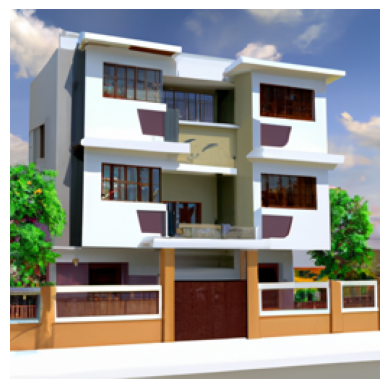

In [36]:
import matplotlib.pyplot as plt

print("Here are real states that you might be intereseted!")
print("-"*60, "\n\n")

for i in range(0, len(matching_listing)-1, 2):
  print(matching_listing[i+1])
  plt.imshow(matching_listing[i])
  plt.axis('off')
  plt.show()

## House matching app

In [39]:
house_matcher_app(match_house=real_state_matcher)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://28d8770b73de46fb01.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
